# SQL Portion

#1. Query to get the top 10 spenders in 2016

Method: Get total sum of item_total per user, Use rank() window function over data set cut by unique users, order results by rank column with highest item_total value as first row, limit result to 10 rows, output user_id, item_total along with rank as final table result. 

Conclusion: 

select user_id, sum, rank(*) over (order by sum desc) as top_spenders
from (
select distinct user_id, sum(item_total) over (partition by user_id) as sum
from orders
order by sum desc) subq
where 3 <= 10;

#2. Query the second highest order item_total for each user, if the user purchased more than once.

Method: Look at all item_totals per user, who purchased more than once. Order the item_totals per user in descending order and rank them. Second ranked item_total per user pulled for final table result.

Conclusion:
 
select user_id, item_total, rank
from
(select user_id, item_total, rank() over (partition by user_id order by item_total desc) as rank
from orders) subq
where rank = 2;

# Python Portion

In [1]:
import pandas as pd
import numpy as np
import plotly.plotly as py
import cufflinks as cf
from plotly import figure_factory as FF
import scipy
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
%matplotlib inline
from scipy import stats
import itertools
import statsmodels.api as sm
from datetime import datetime
import plotly.graph_objs as go

## Import Data and EDA

In [2]:
users = pd.read_csv("users.csv")

In [3]:
users.head()

,id,gender,age,country,days_on_site_in_2016
0,1,M,21,US,1
1,2,F,46,US,10
2,3,NaN,26,US,4
3,4,NaN,54,US,7
4,5,F,34,US,38


In [4]:
users.tail()

,id,gender,age,country,days_on_site_in_2016
9995,9996,NaN,22,US,9
9996,9997,F,50,US,15
9997,9998,NaN,44,US,3
9998,9999,M,31,US,28
9999,10000,M,45,US,4


In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
id                      10000 non-null int64
gender                  6690 non-null object
age                     10000 non-null int64
country                 10000 non-null object
days_on_site_in_2016    10000 non-null int64
dtypes: int64(3), object(2)
memory usage: 390.7+ KB


In [6]:
users.describe(exclude=[np.object])

,id,age,days_on_site_in_2016
count,10000.00000,10000.00000,10000.000000
mean,5000.50000,37.57790,10.369800
std,2886.89568,9.83994,9.916132
min,1.00000,21.00000,1.000000
25%,2500.75000,29.00000,3.000000
50%,5000.50000,38.00000,7.000000
75%,7500.25000,46.00000,14.000000
max,10000.00000,54.00000,87.000000


In [7]:
orders = pd.read_csv("orders.csv")

In [8]:
orders.head()

,id,user_id,order_time,item_total,shipping_cost,discounts_applied,payment_reject
0,1,9852,2016-01-01 0:03:11,60.69,10,NaN,False
1,2,2784,2016-01-01 0:09:32,123.91,15,NaN,False
2,3,1619,2016-01-01 0:17:26,119.75,15,NaN,False
3,4,9725,2016-01-01 0:44:04,151.92,15,NaN,False
4,5,8892,2016-01-01 0:52:23,153.27,15,NaN,False


In [9]:
orders.tail()

,id,user_id,order_time,item_total,shipping_cost,discounts_applied,payment_reject
51733,51734,2838,2016-12-31 23:13:17,97.29,10,NaN,False
51734,51735,172,2016-12-31 23:15:35,147.62,15,NaN,False
51735,51736,1974,2016-12-31 23:15:39,159.71,15,NaN,False
51736,51737,2599,2016-12-31 23:24:11,173.22,15,NaN,False
51737,51738,4735,2016-12-31 23:30:38,101.29,20,NaN,False


In [10]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51738 entries, 0 to 51737
Data columns (total 7 columns):
id                   51738 non-null int64
user_id              51738 non-null int64
order_time           51738 non-null object
item_total           51738 non-null float64
shipping_cost        51738 non-null int64
discounts_applied    4300 non-null float64
payment_reject       51738 non-null bool
dtypes: bool(1), float64(2), int64(3), object(1)
memory usage: 2.4+ MB


In [11]:
orders.describe()

,id,user_id,item_total,shipping_cost,discounts_applied
count,51738.000000,51738.000000,51738.000000,51738.000000,4300.0
mean,25869.500000,5006.494646,126.398776,13.994646,5.0
std,14935.618451,2890.480242,35.045324,3.941930,0.0
min,1.000000,2.000000,43.040000,10.000000,5.0
25%,12935.250000,2543.000000,100.750000,10.000000,5.0
50%,25869.500000,4973.000000,126.410000,15.000000,5.0
75%,38803.750000,7487.000000,152.047500,15.000000,5.0
max,51738.000000,10000.000000,222.960000,25.000000,5.0


Checking for data integrity issues in orders table:

In [12]:
orders.isnull().sum()

id                       0
user_id                  0
order_time               0
item_total               0
shipping_cost            0
discounts_applied    47438
payment_reject           0
dtype: int64

In this situation, number of NaN's in discounts_applied is not a concern. Discounts are rare and usually are the case. They are more for incentive/to draw consumers onto platform. This explains <10% used discounts.

Seeing if all user_id's are unique...

In [13]:
user_id_count = orders.groupby(['user_id']).count()

In [14]:
user_id_count.shape

(9115, 6)

**9115** user_id's are unique. This means many are repeated, which is not bad since this means there is retention.

Below is list of users who have visited site most often ordered in descending order. The top result is the most visited user (49 times in 2016).

In [15]:
user_id_count.sort_values(['item_total'],ascending = False).head(10)

,id,order_time,item_total,shipping_cost,discounts_applied,payment_reject
user_id,,,,,,
2638,49,49,49,49,13,49
7420,45,45,45,45,0,45
6431,42,42,42,42,0,42
5319,42,42,42,42,11,42
2954,42,42,42,42,0,42
6790,41,41,41,41,0,41
1759,39,39,39,39,8,39
7984,38,38,38,38,0,38
7206,37,37,37,37,8,37


In [16]:
orders2=orders.sort_values(by=['item_total'], ascending=False)

In [17]:
orders2.head(10)

,id,user_id,order_time,item_total,shipping_cost,discounts_applied,payment_reject
48139,48140,8134,2016-12-06 16:30:20,222.96,25,5.0,False
20804,20805,7242,2016-05-27 20:57:55,222.49,25,NaN,False
42695,42696,8413,2016-10-29 12:07:15,222.23,25,NaN,False
45745,45746,7242,2016-11-19 21:23:44,221.93,25,NaN,False
18273,18274,6934,2016-05-09 22:03:13,221.54,25,5.0,False
50438,50439,6383,2016-12-22 15:14:26,221.28,25,NaN,False
23053,23054,7242,2016-06-12 22:56:27,221.18,25,NaN,False
4465,4466,6792,2016-02-02 2:10:56,221.17,25,NaN,False
30538,30539,4635,2016-08-05 12:54:36,221.10,25,NaN,False
8621,8622,5800,2016-03-02 9:27:25,220.75,25,NaN,False


The above table outputs top 10 single purchases. This is not considering a single user's multiple purchases and therefore higher spending/user.
So let us try and get some total spend per user.

In [18]:
orders3 = orders.groupby('user_id')['item_total'].sum()
orders3.head(10)

user_id
2     1169.40
3      244.73
4      336.20
5     1887.80
6       96.27
7      707.48
9     2296.28
10    1173.29
11     983.81
13    1796.46
Name: item_total, dtype: float64

### Below, we have a list of users' cumulative item_total spent with highest spender on top. Top 10 spenders listed.

In [19]:
#(Result for 1st SQL question using Pandas)
orders3.sort_values(ascending = False).head(10)

user_id
2638    6530.25
7420    6307.38
6431    6242.29
7984    5836.39
7206    5754.74
9232    5219.75
4547    5218.89
2985    5105.90
2601    5052.97
7958    4901.87
Name: item_total, dtype: float64

## 3. What factors determine the shipping_cost amount?

### Will group shipping_cost amounts into unique amount groups and see where shipping_cost fall in relation to item_total cost and order_time.

First, let's see what all the unique shipping_cost values are to properly subset orders dataframe to smaller dataframes according to different shipping costs.

In [20]:
orders.shipping_cost.unique()

array([10, 15, 25, 20])

In [21]:
grouped = orders.groupby('shipping_cost')

In [22]:
grouped.get_group(10).head(25).sort_values('item_total',ascending=False).describe()

,id,user_id,item_total,shipping_cost,discounts_applied
count,25.00000,25.000000,25.00000,25.0,0.0
mean,40.16000,5150.520000,90.80760,10.0,NaN
std,23.71652,3151.174478,18.98199,0.0,NaN
min,1.00000,285.000000,52.24000,10.0,NaN
25%,19.00000,3098.000000,78.56000,10.0,NaN
50%,34.00000,5102.000000,95.18000,10.0,NaN
75%,62.00000,7953.000000,108.26000,10.0,NaN
max,80.00000,9879.000000,114.68000,10.0,NaN


In [23]:
grouped.get_group(10).head(10).sort_values('item_total',ascending=False)

,id,user_id,order_time,item_total,shipping_cost,discounts_applied,payment_reject
18,19,9879,2016-01-01 3:23:19,114.68,10,NaN,False
12,13,5136,2016-01-01 2:36:13,111.06,10,NaN,False
28,29,4390,2016-01-01 5:13:41,108.54,10,NaN,False
9,10,5102,2016-01-01 1:34:09,108.30,10,NaN,False
15,16,8544,2016-01-01 2:59:25,99.26,10,NaN,False
25,26,7953,2016-01-01 4:31:42,95.18,10,NaN,False
17,18,6430,2016-01-01 3:18:23,80.36,10,NaN,False
29,30,7029,2016-01-01 5:28:19,69.13,10,NaN,False
0,1,9852,2016-01-01 0:03:11,60.69,10,NaN,False
10,11,3098,2016-01-01 2:01:26,59.97,10,NaN,False


In [24]:
grouped.get_group(15).head().sort_values('item_total',ascending=False).describe()

,id,user_id,item_total,shipping_cost,discounts_applied
count,5.000000,5.000000,5.000000,5.0,0.0
mean,4.200000,5473.000000,136.988000,15.0,NaN
std,1.923538,3644.361604,15.468171,0.0,NaN
min,2.000000,1619.000000,119.750000,15.0,NaN
25%,3.000000,2784.000000,123.910000,15.0,NaN
50%,4.000000,4345.000000,136.090000,15.0,NaN
75%,5.000000,8892.000000,151.920000,15.0,NaN
max,7.000000,9725.000000,153.270000,15.0,NaN


In [25]:
grouped.get_group(15).head(10).sort_values('item_total',ascending=False)

,id,user_id,order_time,item_total,shipping_cost,discounts_applied,payment_reject
8,9,3874,2016-01-01 1:28:55,157.27,15,NaN,False
4,5,8892,2016-01-01 0:52:23,153.27,15,NaN,False
3,4,9725,2016-01-01 0:44:04,151.92,15,NaN,False
6,7,4345,2016-01-01 1:10:23,136.09,15,NaN,False
7,8,7779,2016-01-01 1:21:23,134.93,15,NaN,False
14,15,3830,2016-01-01 2:58:19,129.63,15,NaN,False
16,17,636,2016-01-01 3:02:55,129.24,15,NaN,False
11,12,6584,2016-01-01 2:19:47,124.92,15,NaN,False
1,2,2784,2016-01-01 0:09:32,123.91,15,NaN,False
2,3,1619,2016-01-01 0:17:26,119.75,15,NaN,False


In [26]:
grouped.get_group(20).head().sort_values('item_total',ascending=False).describe()

,id,user_id,item_total,shipping_cost,discounts_applied
count,5.000000,5.000000,5.000000,5.0,1.0
mean,44.600000,3599.400000,100.854000,20.0,5.0
std,34.493478,4022.776317,8.556879,0.0,NaN
min,14.000000,33.000000,89.830000,20.0,5.0
25%,24.000000,253.000000,97.700000,20.0,5.0
50%,27.000000,1869.000000,100.720000,20.0,5.0
75%,60.000000,7438.000000,102.580000,20.0,5.0
max,98.000000,8404.000000,113.440000,20.0,5.0


In [27]:
grouped.get_group(20).head(10).sort_values('item_total',ascending=False)

,id,user_id,order_time,item_total,shipping_cost,discounts_applied,payment_reject
13,14,1869,2016-01-01 2:50:53,113.44,20,NaN,False
386,387,4288,2016-01-03 19:56:48,107.17,20,NaN,False
314,315,2813,2016-01-03 8:20:20,106.49,20,NaN,False
26,27,7438,2016-01-01 4:46:08,102.58,20,5.0,False
341,342,1864,2016-01-03 12:46:30,101.04,20,NaN,False
59,60,8404,2016-01-01 12:10:18,100.72,20,NaN,False
23,24,253,2016-01-01 4:18:59,97.70,20,NaN,False
346,347,1856,2016-01-03 13:06:10,93.75,20,NaN,False
97,98,33,2016-01-01 19:14:25,89.83,20,NaN,False
335,336,5986,2016-01-03 11:30:55,82.44,20,NaN,False


In [28]:
grouped.get_group(25).head(25).sort_values('item_total',ascending=False).describe()

,id,user_id,item_total,shipping_cost,discounts_applied
count,25.00000,25.000000,25.000000,25.0,3.0
mean,197.16000,5599.160000,151.316400,25.0,5.0
std,89.04759,3562.667244,26.422798,0.0,0.0
min,6.00000,225.000000,115.310000,25.0,5.0
25%,152.00000,1839.000000,130.320000,25.0,5.0
50%,201.00000,6376.000000,144.810000,25.0,5.0
75%,256.00000,9232.000000,161.060000,25.0,5.0
max,346.00000,9924.000000,213.990000,25.0,5.0


In [29]:
grouped.get_group(25).head(10).sort_values('item_total',ascending=False)

,id,user_id,order_time,item_total,shipping_cost,discounts_applied,payment_reject
151,152,813,2016-01-02 5:36:08,213.99,25,NaN,False
70,71,6376,2016-01-01 14:30:26,169.27,25,5.0,False
99,100,906,2016-01-01 19:54:00,161.06,25,NaN,False
5,6,7105,2016-01-01 1:03:20,156.86,25,NaN,False
78,79,3040,2016-01-01 16:13:22,155.17,25,NaN,False
173,174,8961,2016-01-02 9:28:15,152.44,25,NaN,False
44,45,4665,2016-01-01 9:18:08,150.81,25,NaN,False
159,160,9776,2016-01-02 6:52:18,148.25,25,NaN,False
179,180,1064,2016-01-02 10:12:05,142.48,25,NaN,False
149,150,965,2016-01-02 5:25:06,129.65,25,NaN,False


Shipping Price set at **10 dollars**, **15 dollars**, **20 dollars** and **25 dollars** are all independent of order_time, and more so dependent upon item_total. Item_totals for shipping_cost group are: 
10 | **82.24** - **114.68**
15 | **119.75** - **153.27**
20 | **89.83** - **113.44**
25 | **115.31** - **213.99**

Therefore, based on item_total ranges, shipping costs seem to be determined based on two brackets: 
10-15 | **82.24** - **153.27**
20-25 | **89.83** - **213.99**

## Trends in Consumer Behavior

First, need to combine user table with orders table to get a holistic view of user.

In [30]:
users.head()

,id,gender,age,country,days_on_site_in_2016
0,1,M,21,US,1
1,2,F,46,US,10
2,3,NaN,26,US,4
3,4,NaN,54,US,7
4,5,F,34,US,38


In [31]:
orders.head()

,id,user_id,order_time,item_total,shipping_cost,discounts_applied,payment_reject
0,1,9852,2016-01-01 0:03:11,60.69,10,NaN,False
1,2,2784,2016-01-01 0:09:32,123.91,15,NaN,False
2,3,1619,2016-01-01 0:17:26,119.75,15,NaN,False
3,4,9725,2016-01-01 0:44:04,151.92,15,NaN,False
4,5,8892,2016-01-01 0:52:23,153.27,15,NaN,False


In [32]:
full = pd.merge(users, orders, on='id', how='inner', suffixes=('_users_id', '_users_info'))
full.head(5)

,id,gender,age,country,days_on_site_in_2016,user_id,order_time,item_total,shipping_cost,discounts_applied,payment_reject
0,1,M,21,US,1,9852,2016-01-01 0:03:11,60.69,10,NaN,False
1,2,F,46,US,10,2784,2016-01-01 0:09:32,123.91,15,NaN,False
2,3,NaN,26,US,4,1619,2016-01-01 0:17:26,119.75,15,NaN,False
3,4,NaN,54,US,7,9725,2016-01-01 0:44:04,151.92,15,NaN,False
4,5,F,34,US,38,8892,2016-01-01 0:52:23,153.27,15,NaN,False


### Some Descriptive Statistics

In [33]:
gender = full.gender.value_counts(normalize=0)
gender

F    3405
M    3285
Name: gender, dtype: int64

In [34]:
pie_chart = [go.Pie(labels = gender.index, values = gender )]
py.iplot(go.Figure(data=pie_chart, layout = go.Layout(title= 'Gender Proportions')))

Suprisingly, for a male-curated site, gender of consumers split pretty evently between Males and Females.

In [35]:
series1 = full['age'].value_counts()
series1.head()

54    325
30    319
29    317
34    317
51    313
Name: age, dtype: int64

In [36]:
full.age.describe()

count    10000.00000
mean        37.57790
std          9.83994
min         21.00000
25%         29.00000
50%         38.00000
75%         46.00000
max         54.00000
Name: age, dtype: float64

In [37]:
#Scroll over each bar :)

series1.iplot(kind='bar', yTitle='Count', title='Distribution of Age')

Market has  huge age range (age 21-54). This is good since target market is not narrow, such as market just for millenials.

In [38]:
full.country.unique()

array(['US', 'CA'], dtype=object)

All consumers are from America. There was some input error since CA is not a country, but a state.

In [39]:
payment_reject_counts = full['payment_reject'].value_counts()
payment_reject_counts.head()

False    9898
True      102
Name: payment_reject, dtype: int64

### Comparisons between different columns to explore consumer behavior

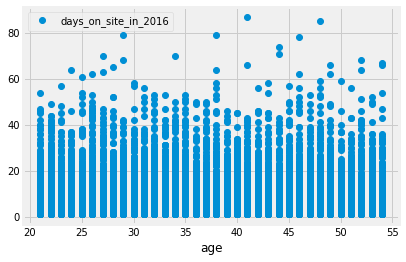

In [40]:
full.plot(x='age', y='days_on_site_in_2016', style='o')

Ages that visited the site most in 2016 were approximately: 20, 40 and 47. This is a wide spectrum. This means that not one cohort/age group is visiting the site frequently.

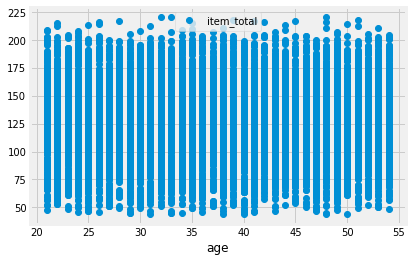

In [41]:
full.plot(x='age', y='item_total', style='o')

Visually, this looks like each group spends about the same, approximately $212. This is another good observation since it looks like not one age group outspends. If so, this would mean having to readjust marketing strategy to get other age groups' sales numbers up.

Last observation, would be to see over the span of 3 months of 2016 data, what is the item_total.

In [42]:
#Format time data to Pandas friendly format
full['order_time']=pd.to_datetime(full['order_time'])

In [43]:
data = [go.Scatter( x=full['order_time'], y=full['item_total'] )]

In [44]:
py.iplot(data)

For each day, there is a 24 hour period. And there are multiple entries per day. This is why there is more data spread vertically than there is data spread across over time. Overall, spending trend appears consistent/no seasonality which is good for overall sales.

### Lastly, data integrity issues:

In [45]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 11 columns):
id                      10000 non-null int64
gender                  6690 non-null object
age                     10000 non-null int64
country                 10000 non-null object
days_on_site_in_2016    10000 non-null int64
user_id                 10000 non-null int64
order_time              10000 non-null datetime64[ns]
item_total              10000 non-null float64
shipping_cost           10000 non-null int64
discounts_applied       809 non-null float64
payment_reject          10000 non-null bool
dtypes: bool(1), datetime64[ns](1), float64(2), int64(5), object(2)
memory usage: 869.1+ KB


In [46]:
full.isnull().sum()

id                         0
gender                  3310
age                        0
country                    0
days_on_site_in_2016       0
user_id                    0
order_time                 0
item_total                 0
shipping_cost              0
discounts_applied       9191
payment_reject             0
dtype: int64

Gender column is missing a third of its data, there is some mix-up with CA being a country. This is to be considered when wanting to make serious business decisions based on lack of data. However, company moves forward usually based on total sales (item_total) and not based on gender and country of origin data. Therefore, missing data does not skew e-commerce data assessment at all. 